# Detecting Breast Cancer With Federated Learning - JEFFFREY ROWLINGS

# Introduction

Dataset Source - https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/

## Installing dependencies and intial setup

In [2]:
# install PyTorch

!pip install -q torchvision==0.2.1
!pip install -q torch==1.0.0
import torch

     |████████████████████████████████| 61kB 4.0MB/s 
     |████████████████████████████████| 591.8MB 24kB/s 


In [3]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall -qy Pillow
# install the new one
!pip install -q Pillow==5.3.0
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime
# since the input images are quite large, we will disable the size check
PIL.Image.MAX_IMAGE_PIXELS = None

ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
5.3.0


In [7]:
# we need to download the dataset
!pip install gdown

## Required Imports

In [ ]:
# Imports here
import os
import time
from collections import OrderedDict
from datetime import datetime
from pytz import timezone  
import copy

import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

## Load the data

Here we will use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The dataset is split into two parts, training and validation. 

In [10]:
!gdown https://drive.google.com/uc?id=1NezEReRhMzrbQLUlExfdGjo2jw6hUcSU

Downloading...
From: https://drive.google.com/uc?id=1NezEReRhMzrbQLUlExfdGjo2jw6hUcSU
To: /content/b_cancer_data2.zip
4.28GB [00:28, 151MB/s]


In [ ]:
!rm -rf b_cancer_data2 b_cancer_data || true
!unzip -qq b_cancer_data2.zip
!mv b_cancer_data2 b_cancer_data
!rm b_cancer_data2.zip || true

In [15]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(), # randomly flip and rotate
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'b_cancer_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("selected: ", device)

selected:  cuda


In [ ]:
# set timezone
my_timezone = timezone('Asia/Kolkata')

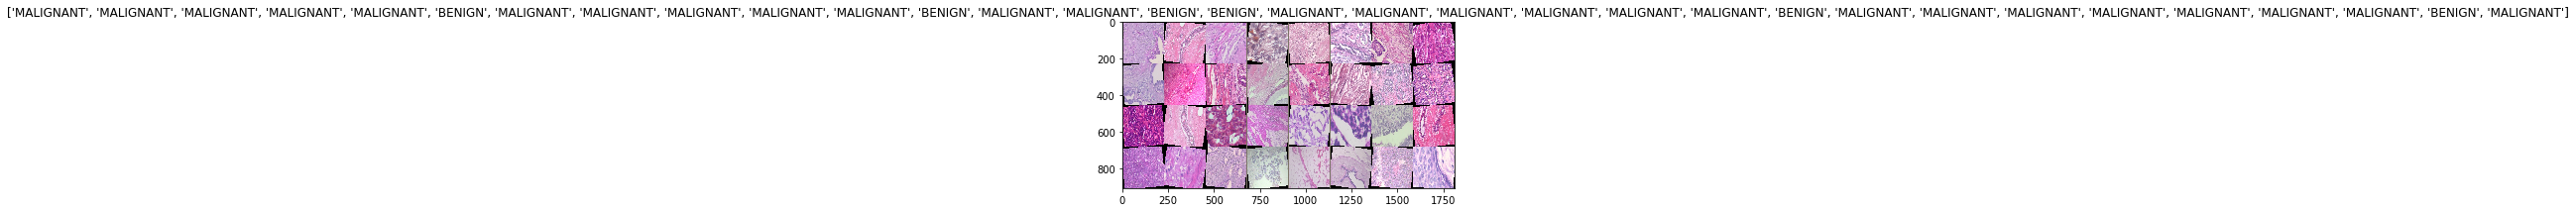

In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Building and training the classifier

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{} at {}'.format(epoch, num_epochs - 1, datetime.now(my_timezone).strftime('%I:%M:%S %p (%d %b %Y)')))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [22]:
# super simplified
model = models.densenet121(pretrained=True)

for param in model.parameters():
  param.requires_grad = True

model.classifier = nn.Linear(1024, 2)
model = model.to(device)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [ ]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.006, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [24]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

Epoch 0/4 at 02:35:38 PM (18 Aug 2019)
----------
train Loss: 0.2713 Acc: 0.8908
valid Loss: 0.2977 Acc: 0.8836
Epoch 1/4 at 02:37:31 PM (18 Aug 2019)
----------
train Loss: 0.1456 Acc: 0.9448
valid Loss: 0.3907 Acc: 0.8555
Epoch 2/4 at 02:39:22 PM (18 Aug 2019)
----------
train Loss: 0.0774 Acc: 0.9723
valid Loss: 0.4271 Acc: 0.8747
Epoch 3/4 at 02:41:13 PM (18 Aug 2019)
----------
train Loss: 0.0553 Acc: 0.9836
valid Loss: 0.3572 Acc: 0.8843
Epoch 4/4 at 02:43:03 PM (18 Aug 2019)
----------
train Loss: 0.0353 Acc: 0.9888
valid Loss: 0.3699 Acc: 0.8849
Training complete in 9m 16s
Best val Acc: 0.884910


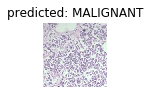

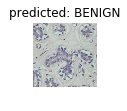

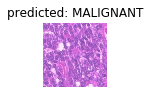

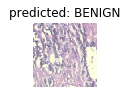

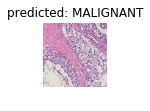

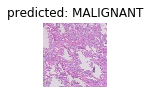

In [25]:
visualize_model(model)

### Save the model

In [ ]:
torch.save(model.state_dict(), "non_federated_breast_cancer_cnn.pt")

## Federated Learning

In [ ]:
!pip install syft

In [ ]:
# little hack for pytorch/pysyft compat
torch.set_default_tensor_type(torch.cuda.FloatTensor)

## Initial Data Setup

In [ ]:
import syft as sy
hook = sy.TorchHook(torch)

In [ ]:
hospital_1 = sy.VirtualWorker(hook, id="hospital_1")
hospital_2 = sy.VirtualWorker(hook, id="hospital_2")

In [ ]:
class Arguments():
    def __init__(self):
        self.batch_size = 32
        self.test_batch_size = 32
        self.epochs = 4
        self.lr = 0.006
        self.momentum = 0.9
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 10
        self.save_model = False

args = Arguments()
torch.manual_seed(args.seed)

In [ ]:
train_data = image_datasets['train']
train_data.data = train_data.imgs

In [ ]:
federated_train_loader = sy.FederatedDataLoader(train_data.federate((hospital_1, hospital_2)), batch_size=args.batch_size, shuffle=True)

In [ ]:
dataloaders['train'] = federated_train_loader

## Federated Training

In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

### Save the model

In [ ]:
torch.save(model.state_dict(), "federated_breast_cancer_cnn.pt")